# Introdução

Um campo agrícola possui um conjunto de **20 sensores distribuídos ao longo de 3 campos de cultivo distintos**, aqui chamados de parcelas 1, 2 e 3. Os sensores medem, entre outras coisas, a umidade do solo, a radiação solar, etc. Foram coletadas 2000 observações destes sensores, de acordo com uma frequência X
. Em cada observação constam os valores das condições climáticas registradas pelos sensores e , também, indica qual parcela de campo foi irrigada ou não naquela ocasião.

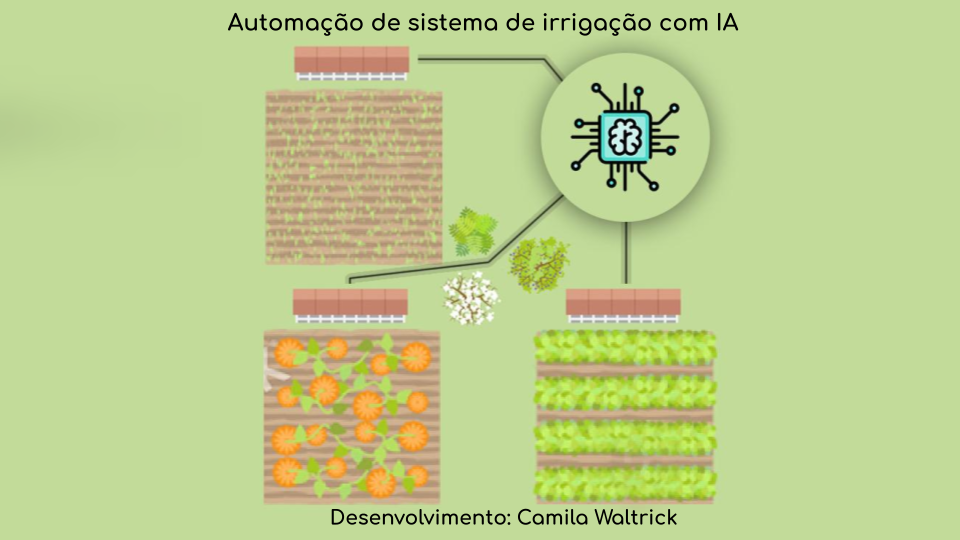

*   O objetivo deste estudo é prever quando as parcelas do campo devem ser irrigadas ou não, usando a combinação de medições dos sensores para decidir, visto que cada local possui requisitos ambientais diferentes.

*   Cada sensor mede um valor inteiro entre 0 e 13 volts e vamos assumir esse intervalo como normalizado (num problema do mundo real, acrescentaríamos aqui uma etapa de pré processamento dos dados). Os campos estão representados aqui como parcelas da fazenda (parcel_0, parcel_1 e parcel_2), pois já foram codificados com one-hot, conforme esperado pelas especificidades do modelo que será construído com redes neurais. Premissa: Neste sistema de irrigação, as parcelas podem ser regadas simultaneamente.

## Metodologia
Para a solução deste problema de negócio, será utilizada a abordagem multi-label classification com redes neurais, onde cada observação poderá ser rotulada com uma, nenhuma ou N classes necessárias. Portanto, as classes/rótulos não são mutuamente exclusivos, já que podemos regar todas, nenhuma ou qualquer combinação de parcelas com base nos insumos.

Spoiler: Para explicar esse comportamento, o que fazemos é ter uma camada de saída com a quantidade de neurônios igual a quantidade de classes desejadas na previsão do modelo, utilizando a função de ativação sigmóide. Isso torna cada neurônio na camada de saída capaz de gerar um número entre 0 e 1, independentemente.

# Desenvolvimento

## Dataset

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Este é um conjunto de dados tratado para fins experimentais sobre deep learning, onde o foco é partir direto para a modelagem das redes neurais. Desta forma, os dados não passarão por técnicas de pré processamento, as quais seriam necessárias em outros casos.

In [2]:
# Vamos carregar e conhecer os dados
df = pd.read_csv('/content/irrigation_machine.csv', index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sensor_0   2000 non-null   float64
 1   sensor_1   2000 non-null   float64
 2   sensor_2   2000 non-null   float64
 3   sensor_3   2000 non-null   float64
 4   sensor_4   2000 non-null   float64
 5   sensor_5   2000 non-null   float64
 6   sensor_6   2000 non-null   float64
 7   sensor_7   2000 non-null   float64
 8   sensor_8   2000 non-null   float64
 9   sensor_9   2000 non-null   float64
 10  sensor_10  2000 non-null   float64
 11  sensor_11  2000 non-null   float64
 12  sensor_12  2000 non-null   float64
 13  sensor_13  2000 non-null   float64
 14  sensor_14  2000 non-null   float64
 15  sensor_15  2000 non-null   float64
 16  sensor_16  2000 non-null   float64
 17  sensor_17  2000 non-null   float64
 18  sensor_18  2000 non-null   float64
 19  sensor_19  2000 non-null   float64
 20  parcel_0

In [4]:
df.head()

,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,parcel_0,parcel_1,parcel_2
0,1.0,2.0,1.0,7.0,0.0,1.0,1.0,4.0,0.0,3.0,1.0,3.0,6.0,8.0,1.0,0.0,2.0,1.0,9.0,2.0,0,1,0
1,5.0,1.0,3.0,5.0,2.0,2.0,1.0,2.0,3.0,1.0,3.0,2.0,2.0,4.0,5.0,5.0,2.0,2.0,2.0,7.0,0,0,0
2,3.0,1.0,4.0,3.0,4.0,0.0,1.0,6.0,0.0,2.0,3.0,2.0,4.0,3.0,3.0,1.0,0.0,3.0,1.0,0.0,1,1,0
3,2.0,2.0,4.0,3.0,5.0,0.0,3.0,2.0,2.0,5.0,3.0,1.0,2.0,4.0,1.0,1.0,4.0,1.0,3.0,2.0,0,0,0
4,4.0,3.0,3.0,2.0,5.0,1.0,3.0,1.0,1.0,2.0,4.0,5.0,3.0,1.0,3.0,2.0,2.0,1.0,1.0,0.0,1,1,0


In [5]:
df.columns

Index(['sensor_0', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5',
       'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10',
       'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'parcel_0',
       'parcel_1', 'parcel_2'],
      dtype='object')

In [6]:
# Separar os dados dos sensores e os dados das parcelas, onde temos a informação do que foi regado
sensors = df[['sensor_0', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5',
       'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10',
       'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19']].values
parcels = df[['parcel_0',
       'parcel_1', 'parcel_2']].values

# Dividir em dados de treino e teste
sensors_train, sensors_test, parcels_train, parcels_test = train_test_split(sensors, parcels, test_size = 0.2, random_state = 42)

## Modelo

▶ *No trecho que código a seguir, estarei realizando os seguintes processos:*

1.   **Sequential():** O primeiro passo é criar a instância de um modelo Sequencial. O modelo Sequencial é uma pilha linear de camadas que você pode criar facilmente passando uma lista de instâncias de camadas para o construtor, que é o que esta sendo feito abaixo.
2.   **Entrada e camada oculta:** Adiciona-se uma camada oculta com 64 neurônios e especifica-se que o formato de entrada é 20. Isso significa que o modelo espera que os dados de entrada tenham o formato (20,*), onde * pode ser qualquer número (representando o número de amostras) e 20 representa o número de recursos ou sensores, nesse caso. A função de ativação usada nesta camada é 'relu' - Unidade Linear Retificada, que é uma função de ativação comum em redes neurais. Entretando, é possível a experimentação de outras funções de ativação nessa camada, a fim de buscar aquela que melhore o desempenho do modelo.
3. **Camada de saída:** Aqui é adicionada uma camada de saída com 3 neurônios. A função de ativação usada aqui é sigmóide. A função sigmóide é comumente usada na camada de saída de um problema de classificação binária, onde os valores de saída podem ser interpretados como probabilidades para as classes.
4. **compile():** Compila o modelo usando o otimizador 'adam' e a perda 'binary_crossentropy'. O otimizador Adam é uma extensão da descida gradiente estocástica, que é um algoritmo de otimização eficiente e popular em aprendizado profundo. A entropia cruzada binária é uma função de perda comum para problemas de classificação binária.
5. **summary():** Imprime um resumo do modelo, que inclui os tipos de camadas usadas, suas formas e o número de parâmetros.

Portanto, esta solução configura uma rede neural simples para um problema de classificação binária com as especificações necessárias para o sistemas de irrigação.

In [7]:
# Instanciar um modelo sequencial
model = Sequential()

# Adicionar uma camada oculta de 64 neurônios e uma entrada de 20 neurônios
model.add(Dense(64, input_shape=(20,), activation='relu'))

# Adicionar uma camada de saída de 3 neurônios com ativação sigmóide
model.add(Dense(3, activation='sigmoid'))

# Compilar o modelo com binary crossentropy loss
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1539 (6.01 KB)
Trainable params: 1539 (6.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


▶  *O que será obtido como saída desse modelo?*

*   Como se trata de um caso de classificação multi rótulo, a saída desejável para este modelo é uma matriz numpy, seria algo como [0.76 , 0.99 , 0.66 ]. Isso são probabilidades, então, aos arredontar as probabilidades superiores a 0.5, esta observação será classificada como contendo todos os 3 rótulos possíveis, ficaria [1,1,1]. Para este problema específico, isso significaria que regar todas as 3 parcelas da fazenda é a coisa certa a fazer, de acordo com a rede, dadas as medições do sensor de entrada. Vamos ver como isso acontece:


▶ *No trecho que código a seguir, estarei realizando os seguintes processos:*

1.   **EarlyStopping():** Instancia a parada antecipada, que é utilizada como callback no fit. Sua função é interromper o treinamento quando o modelo não melhora mais, ajudando a resolver o problema de overfitting. A parada antecipada pode monitorar diversas métricas, especificadas no parâmetro monitor. Também é importante definir um argumento de paciência, que é o número de épocas de espera para que o modelo melhore antes de interromper seu treinamento. Não há regras para decidir qual número de paciência funciona melhor em todos os momentos, isso depende da implementação. É bom evitar valores muito baixos.
2. **fit():** Ttreina o modelo usando os dados de treinamento, jde acordo com  o número de épocas e aplica uma divisão nos dados de treino para que uma parte seja usada para validação. Isso significa que o modelo será treinado para 100 iterações em todo o conjunto de dados e 20% dos dados de treinamento serão usados ​​para validação após cada época. Por fim, indica o callback que será realizado.
3. **h_callback.history:** O callback do histórico é retornado por padrão ao treinar um modelo com o fit(), aqui salvo na variável *h_callback* para ser acessado. Este objeto possui um atributo que é um registro de valores de perda de treinamento e valores de métricas em épocas sucessivas, bem como valores de perda de validação e valores de métricas de validação (se aplicável).
4. **plot_loss e plot_accuracy:** Representa graficamente a perda e a acurácia, respectivamente, do modelo nos dados de treinamento e validação em função do número da época. Isso permite ver como o desempenho do modelo melhora ao longo do tempo. O overfitting ocorre quando, com o passar das épocas, a perda piora nos dados de validação (ou seja, começa a aumentar no gráfico), isso demonstra que o modelo está perdendo o poder de generalização.

In [8]:
# Instanciar um callback de parada antecipada
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

# Treinamento
h_callback = model.fit(sensors_train, parcels_train, epochs=100, validation_split=0.2, callbacks = [early_stopping])

Epoch 1/100
40/40 [==============================] - 1s 10ms/step - loss: 0.6644 - accuracy: 0.4469 - val_loss: 0.5041 - val_accuracy: 0.5406
Epoch 2/100
40/40 [==============================] - 0s 5ms/step - loss: 0.4610 - accuracy: 0.5852 - val_loss: 0.4135 - val_accuracy: 0.5969
Epoch 3/100
40/40 [==============================] - 0s 6ms/step - loss: 0.3901 - accuracy: 0.5992 - val_loss: 0.3629 - val_accuracy: 0.5906
Epoch 4/100
40/40 [==============================] - 0s 6ms/step - loss: 0.3527 - accuracy: 0.6234 - val_loss: 0.3360 - val_accuracy: 0.6187
Epoch 5/100
40/40 [==============================] - 0s 5ms/step - loss: 0.3283 - accuracy: 0.6195 - val_loss: 0.3117 - val_accuracy: 0.6125
Epoch 6/100
40/40 [==============================] - 0s 6ms/step - loss: 0.3138 - accuracy: 0.6211 - val_loss: 0.2952 - val_accuracy: 0.6281
Epoch 7/100
40/40 [==============================] - 0s 7ms/step - loss: 0.2988 - accuracy: 0.6281 - val_loss: 0.2857 - val_accuracy: 0.5750
Epoch 8/100


In [9]:
def plot_loss(loss,val_loss):
# Plotar valores de perda de treinamento e validação
  plt.figure()
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Perda do modelo no treinamento')
  plt.ylabel('Perda')
  plt.xlabel('Épocas')
  plt.legend(['Treino', 'Validação'], loc='upper right')
  plt.show()

In [10]:
def plot_accuracy(acc,val_acc):
# Plotar valores de acurácia de treinamento e validação
  plt.figure()
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('Acurácia do modelo no treinamento')
  plt.ylabel('Acurácia')
  plt.xlabel('Épocas')
  plt.legend(['Treino', 'Validação'], loc='upper left')
  plt.show()

In [22]:
len(h_callback.history['loss'])

53

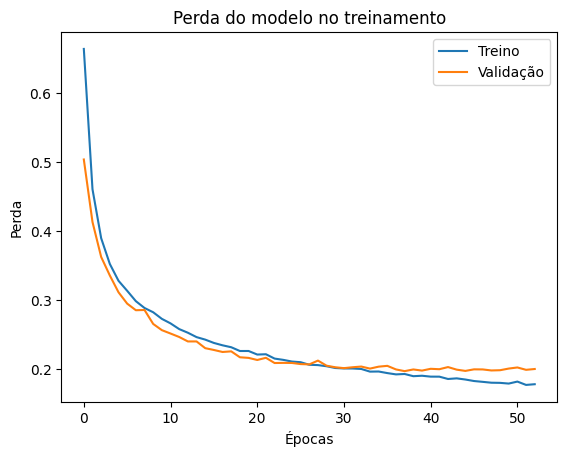

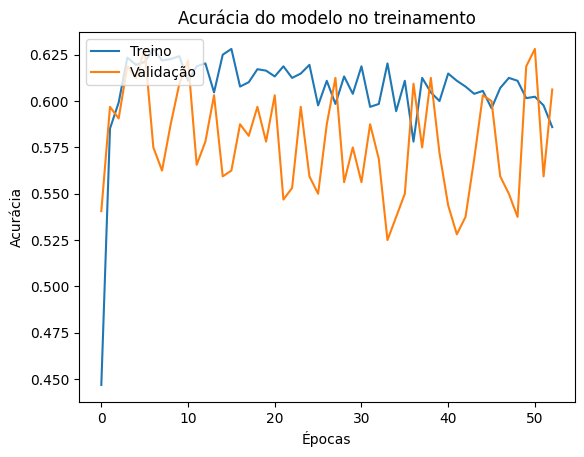

In [11]:
# Plotar perda durante o treinamento
plot_loss(h_callback.history['loss'], h_callback.history['val_loss'])

# Plotar acurácia durante o treinamento
plot_accuracy(h_callback.history['accuracy'], h_callback.history['val_accuracy'])

In [24]:
print(h_callback.history['accuracy'])

[0.4468750059604645, 0.585156261920929, 0.5992187261581421, 0.6234375238418579, 0.6195312738418579, 0.62109375, 0.628125011920929, 0.621874988079071, 0.6226562261581421, 0.624218761920929, 0.6109374761581421, 0.6187499761581421, 0.620312511920929, 0.604687511920929, 0.625, 0.628125011920929, 0.6078125238418579, 0.610156238079071, 0.6171875, 0.616406261920929, 0.61328125, 0.6187499761581421, 0.612500011920929, 0.6148437261581421, 0.6195312738418579, 0.59765625, 0.6109374761581421, 0.598437488079071, 0.61328125, 0.6039062738418579, 0.6187499761581421, 0.596875011920929, 0.598437488079071, 0.620312511920929, 0.594531238079071, 0.6109374761581421, 0.578125, 0.612500011920929, 0.604687511920929, 0.6000000238418579, 0.6148437261581421, 0.6109374761581421, 0.6078125238418579, 0.6039062738418579, 0.60546875, 0.5960937738418579, 0.6070312261581421, 0.612500011920929, 0.6109374761581421, 0.6015625, 0.602343738079071, 0.59765625, 0.5859375]


In [25]:
print(h_callback.history['val_accuracy'])

[0.5406249761581421, 0.596875011920929, 0.590624988079071, 0.6187499761581421, 0.612500011920929, 0.628125011920929, 0.574999988079071, 0.5625, 0.5874999761581421, 0.609375, 0.621874988079071, 0.565625011920929, 0.578125, 0.6031249761581421, 0.559374988079071, 0.5625, 0.5874999761581421, 0.581250011920929, 0.596875011920929, 0.578125, 0.6031249761581421, 0.546875, 0.5531250238418579, 0.596875011920929, 0.559374988079071, 0.550000011920929, 0.5874999761581421, 0.612500011920929, 0.5562499761581421, 0.574999988079071, 0.5562499761581421, 0.5874999761581421, 0.5687500238418579, 0.5249999761581421, 0.5375000238418579, 0.550000011920929, 0.609375, 0.574999988079071, 0.612500011920929, 0.5718749761581421, 0.543749988079071, 0.528124988079071, 0.5375000238418579, 0.5687500238418579, 0.6031249761581421, 0.6000000238418579, 0.559374988079071, 0.550000011920929, 0.5375000238418579, 0.6187499761581421, 0.628125011920929, 0.559374988079071, 0.606249988079071]


In [27]:
print(h_callback.history['loss'])

[0.6644091010093689, 0.461010217666626, 0.39005136489868164, 0.35267898440361023, 0.3283245265483856, 0.31379759311676025, 0.2987852096557617, 0.2888854146003723, 0.2826910614967346, 0.27312570810317993, 0.26656752824783325, 0.2582896649837494, 0.25301212072372437, 0.24667206406593323, 0.24302978813648224, 0.23822052776813507, 0.23478710651397705, 0.23199479281902313, 0.22653336822986603, 0.22655780613422394, 0.22139973938465118, 0.22183184325695038, 0.2155514508485794, 0.2136986255645752, 0.21125295758247375, 0.21029940247535706, 0.20658771693706512, 0.20610757172107697, 0.2044312059879303, 0.20188912749290466, 0.20124101638793945, 0.201176717877388, 0.20049278438091278, 0.19664958119392395, 0.1968122273683548, 0.19452717900276184, 0.19263955950737, 0.1932244598865509, 0.1900237500667572, 0.19068001210689545, 0.18938477337360382, 0.18935264647006989, 0.18598267436027527, 0.18688204884529114, 0.1852036714553833, 0.18301159143447876, 0.1818242073059082, 0.18057192862033844, 0.1803635954

In [26]:
print(h_callback.history['val_loss'])

[0.5041431784629822, 0.41351327300071716, 0.3628637194633484, 0.3359924256801605, 0.3116620182991028, 0.2952139973640442, 0.28565406799316406, 0.2859848737716675, 0.26575666666030884, 0.25675979256629944, 0.25186166167259216, 0.24684575200080872, 0.24039986729621887, 0.24039487540721893, 0.2306515872478485, 0.22803029417991638, 0.22511419653892517, 0.22602272033691406, 0.21744951605796814, 0.21655967831611633, 0.21352382004261017, 0.21667690575122833, 0.20911350846290588, 0.20933043956756592, 0.20920029282569885, 0.20759129524230957, 0.2071201503276825, 0.21263721585273743, 0.2052260935306549, 0.20295469462871552, 0.20169587433338165, 0.20298361778259277, 0.20399153232574463, 0.20104150474071503, 0.2038394659757614, 0.20502014458179474, 0.19981935620307922, 0.1973479688167572, 0.19979247450828552, 0.19814026355743408, 0.2007453739643097, 0.20013582706451416, 0.20324751734733582, 0.1995128095149994, 0.1976829469203949, 0.1999523937702179, 0.19982627034187317, 0.1983398199081421, 0.19868

▶ *Interpretando as curvas de aprendizados dos gráficos e o desempenho do modelo no treinamento:*

* A **parada antecipada** ocorreu na 53ª época, antes que ele começasse a sobreajustar (overfitting ocorre quando o modelo começa a aprender particularidades nos dados de treinamento que não generalizam bem em dados novos). Ou seja, de acordo com o monitoramento da perda do conjunto da validação e a espera configurada, o modelo foi efetivamente treinado com 53 épocas, pois a partir disso ele não estaria melhorando.
* A curva da **perda** tende a diminuir com o passar das épocas. Isso é esperado, pois o modelo está essencialmente aprendendo a minimizar a função de perda. Com o passar das épocas, o valor de perda diminuiu. Depois de um certo número de épocas, o valor converge, o que significa que não fica mais abaixo disso. Chegamos ao mínimo.
* A curva da **acurácia** é semelhante, mas com tendências opostas. Neste caso, tende a aumentar com o passar das épocas. Isso mostra que o modelo comete menos erros à medida que aprende. Na prática, não foi obtida uma curva (ainda), pois nem todas as curvas são suaves e bonitas, muitas vezes encontraremos curvas instáveis. Existem muitas razões que podem levar a curvas de aprendizagem instáveis com essa obtida na acurácia: o otimizador escolhido, taxa de aprendizado, tamanho do lote, arquitetura de rede, inicialização de peso, etc. Todos esses hiperparâmetros podem ser ajustados para melhorar as curvas de aprendizado do modelo, pois buscamos melhor acurácia e poder de generalização.

* Sugestão de próximos passos:
  * Otimização dos hiperparâmentros.


▶ *No trecho que código a seguir, estarei realizando os seguintes processos:*

1. **predict():** o modelo é usado para fazer previsões sobre os dados de teste. As previsões são então arredondadas para o número inteiro mais próximo (0 ou 1) usando a função np.round função.
2. **evaluate():** Avalia o desempenho do modelo nos dados de teste. Este método retorna o valor de perda e os valores de métricas para o modelo no modo de teste. O segundo valor na lista retornada é a acurácia do modelo, o que nos dá uma medida do desempenho do modelo em dados não vistos.

In [13]:
# Prever com sensors_test e arredondar as previsões
preds = model.predict(sensors_test)
preds_rounded = np.round(preds)

# Imprimir as previsões arredondadas
print('Previsões do modelo: \n', preds_rounded)

13/13 [==============================] - 0s 2ms/step
Previsões do modelo: 
 [[1. 1. 0.]
 [0. 0. 0.]
 [1. 1. 0.]
 ...
 [0. 0. 0.]
 [1. 1. 0.]
 [0. 1. 0.]]


In [14]:
# Avaliar a acurácia do modelo nos dados de teste
accuracy = model.evaluate(sensors_test, parcels_test)[1]

# Imprimir a acurácia
print('Acurácia do modelos nos dados não vistos:', accuracy)

13/13 [==============================] - 0s 2ms/step - loss: 0.2255 - accuracy: 0.6300
Acurácia do modelos nos dados não vistos: 0.6299999952316284


▶ *Interpretando o desempenho final do modelo no treinamento:*

* Com o conjuntos de novos dados, foi possível obter uma acurácia melhor que a anterior, porém fica a observação de que este é um modelo com arquiterura básica de redes neurais. Obviamente num caso de uso real, teríamos várias melhorias para aplicar, as quais nos beneficiariam com melhor poder preditivo.  
* Além da otimização de hiperparâmetros, outra possibilidade de melhoria seria a obtenção de mais dados. As redes neurais são conhecidas por superar as técnicas tradicionais de aprendizado de máquina à medida que aumentamos o tamanho de nossos conjuntos de dados. Será que este modelo seria beneficiado com isso, também?